***STEPS FOR QUERYING STRUCTURAL VARIANT VCF FILE, GETTING THE INTERSECT WITH GOOD SAMPLOTS, AND PLOTTING THE PCA***

***PART 1. PLOT THE INTERSECT OF ALL DELETIONS GIVEN "YES" OR "MAYBE" BY ALL CURATORS***

Query the Smoove .vcf file for all SV calls with alternate genotypes

In [1]:
#%%bash
#VCF=sparrow_all.smoove.square.vcf.gz

#bcftools query -f '%CHROM\t%POS\t%END\t%ALT[\t%GT]\n' ${VCF} | sort -k1,1 -k2,2n | grep CM | grep -v '\[' | grep -v '\]' | sed 's/<DEL>/DEL/g' | sed 's/<DUP>/DUP/g' | sed 's/<INV>/INV/g' > SV_altgenos.bed

STEP 1 - filter out only the Good calls in the report:

Filter for number of SVs in report by desired person, reorganize columns for order chrom, start pos,stop pos, SV type:

***Filter for both Yes's and Maybe's for each of the five curators***

First set the file names and curator names as variables

Then extract all Yes's and Maybes

In [2]:
%%bash
RAWDEL=raw_report_del_dec23_2020.tsv
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish
#set the SV class
SV=DEL

#Extract all Yes's
cat ${RAWDEL} | grep "${CUR1}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR1}.tsv
cat ${RAWDEL} | grep "${CUR2}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR2}.tsv
cat ${RAWDEL} | grep "${CUR3}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR3}.tsv
cat ${RAWDEL} | grep "${CUR4}" | grep "Yes"| sed '1,3d' > yes_${SV}_${CUR4}.tsv

Now extract all Maybes

In [3]:
%%bash
RAWDEL=raw_report_del_dec23_2020.tsv
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

#set the SV class
SV=DEL

cat ${RAWDEL} | grep "${CUR1}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR1}.tsv
cat ${RAWDEL} | grep "${CUR2}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR2}.tsv
cat ${RAWDEL} | grep "${CUR3}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR3}.tsv
cat ${RAWDEL} | grep "${CUR4}" | grep "Maybe"| sed '1,3d' > maybe_${SV}_${CUR4}.tsv

Now merge Yes's and Maybes for each curator

In [4]:
%%bash
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

#set the SV class
SV=DEL

cat yes_${SV}_${CUR1}.tsv maybe_${SV}_${CUR1}.tsv >>  yesmaybe_${SV}_${CUR1}.tsv
cat yes_${SV}_${CUR2}.tsv maybe_${SV}_${CUR2}.tsv >>  yesmaybe_${SV}_${CUR2}.tsv
cat yes_${SV}_${CUR3}.tsv maybe_${SV}_${CUR3}.tsv >>  yesmaybe_${SV}_${CUR3}.tsv
cat yes_${SV}_${CUR4}.tsv maybe_${SV}_${CUR4}.tsv >>  yesmaybe_${SV}_${CUR4}.tsv

Process the .bed file to extract genotype information for each SV call

In [5]:
%%bash
#set the SV class
SV=DEL
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

cat yesmaybe_${SV}_${CUR1}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR1}_processed.bed 
cat yesmaybe_${SV}_${CUR2}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR2}_processed.bed 
cat yesmaybe_${SV}_${CUR3}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR3}_processed.bed 
cat yesmaybe_${SV}_${CUR4}.tsv | sed 's/_/\t/g' | sed 's/ //'g | awk '{ print $4,$5,$6,$3}' | sed 's/DEL\///g' | sort -k1,1 -k2,2n | sed 's/ /\t/'g > yesmaybe_${SV}_${CUR4}_processed.bed 

First take intersect off all four curators' validated SVs

In [8]:
%%bash
CUR1=gabriel
CUR2=alicia
CUR3=erik
CUR4=hamish

#set the SV class
SV=DEL

bedops --intersect yesmaybe_${SV}_${CUR1}_processed.bed yesmaybe_${SV}_${CUR2}_processed.bed yesmaybe_${SV}_${CUR3}_processed.bed yesmaybe_${SV}_${CUR4}_processed.bed > yesmaybe_allcurators_intersect_${SV}.bed

Now intersect with .bed file extracted from original Smoove .vcf file

In [11]:
%%bash

#set the SV class
SV=DEL

bedtools intersect -f 0.9 -r -a SV_altgenos.bed -b yesmaybe_allcurators_intersect_${SV}.bed  > yesmaybeallintersect.txt

***Change format of intersected bedfile, repeat this to join 3 first columns with tabs***

In [12]:
cat yesmaybeallintersect.txt | sed 's/0\/0/0/g' | sed 's/0\/1/1/g' | sed 's/1\/1/2/g'| sed 's/.\/\./0/g' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' > yesmaybeallintersect_edit.txt 

***Convert to .csv for export to Python, to tranpose matrix***

In [13]:
cat yesmaybeallintersect_edit.txt | sed 's/\t/,/'g > yesmaybeallintersect_edit.csv

In [14]:
import numpy as np
import pandas as pd

df = pd.read_csv("yesmaybeallintersect_edit.csv", header = None, index_col = None)

df_T = df.transpose()

df_T.to_csv("yesmaybeallintersect_T.csv", index = False)

Remove first line

In [15]:
%%bash
sed -i -e 1,1d yesmaybeallintersect_T.csv 

***Now plot in Python!***

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [17]:
df = pd.read_csv("yesmaybeallintersect_T.csv")
hs = pd.read_csv("HS.sample.csv")
df

,CM004525.1_404726_404781_DEL,CM004525.1_450632_450686_DEL,CM004525.1_2793450_2793535_DEL,CM004525.1_3367262_3367328_DEL,CM004525.1_5558809_5559097_DEL,CM004525.1_7403900_7405237_DEL,CM004525.1_7522591_7522670_DEL,CM004525.1_9075437_9075557_DEL,CM004525.1_9813191_9813303_DEL,CM004525.1_10956079_10956149_DEL,...,CM004550.1_246509_247134_DEL,CM004550.1_1236277_1236348_DEL,CM004550.1_1890650_1890710_DEL,CM004550.1_3727001_3727053_DEL,CM004550.1_4313941_4314149_DEL,CM004552.1_1630829_1630907_DEL,CM004552.1_4946308_4946545_DEL,CM004553.1_2614567_2614634_DEL,CM004553.1_2844948_2845034_DEL,CM004554.1_868673_869052_DEL
0,2,0,2,2,2,1,1,0,2,0,...,1,1,0,0,1,1,1,0,0,1
1,2,0,1,0,0,1,2,1,1,0,...,2,0,0,0,1,0,1,2,0,0
2,0,0,0,0,1,1,2,0,1,1,...,0,0,0,1,2,0,0,2,0,0
3,2,1,0,0,0,1,0,0,0,0,...,0,0,0,2,1,0,1,2,0,0
4,2,0,1,2,1,0,0,0,0,1,...,0,0,0,1,2,1,1,0,1,1
5,2,2,0,2,0,0,0,0,1,0,...,1,0,1,1,0,0,2,0,2,2
6,2,0,0,2,1,0,0,0,1,0,...,0,0,0,0,0,0,0,2,0,1
7,0,1,0,1,1,1,2,1,1,0,...,0,0,0,0,2,1,0,2,2,0
8,1,0,1,2,1,1,2,1,0,1,...,1,1,0,0,2,0,0,2,0,1
9,0,2,2,0,1,0,0,0,2,0,...,2,0,1,2,0,0,2,0,2,0


In [18]:
import plotly.express as px
from sklearn.decomposition import PCA

X = df


In [19]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

components 

array([[-2.54584317, -0.7779171 ],
       [-2.37339937, -1.16748465],
       [ 0.63822707,  0.46159391],
       [-1.45944864,  0.78812359],
       [ 0.41238358, -3.22733503],
       [-3.18177676, -5.18141054],
       [-2.61233568, -1.30365593],
       [-8.05848442, 15.88454143],
       [-9.39397559, 15.82020883],
       [-3.91126097, -2.4657187 ],
       [-3.65422744, -2.66914887],
       [17.67855638,  6.92947245],
       [-0.18181468, -1.74914153],
       [ 2.54793499, -4.78809645],
       [14.2732594 ,  2.70350535],
       [-2.36626928, -3.30465962],
       [-1.24947146, -1.49834137],
       [-4.09916483, -4.249517  ],
       [-2.31277415, -4.0680257 ],
       [ 3.27175633, -8.21106477],
       [11.25163378,  3.3885998 ],
       [-0.06018392, -6.11008029],
       [ 1.86705707, -8.11815489],
       [ 0.66153357, -6.17229879],
       [-3.34061936, -6.99818496],
       [-1.20562617, -7.01039541],
       [19.83059477,  8.4090102 ],
       [-3.7221568 ,  0.83084808],
       [ 9.3409353 ,

In [20]:
pcomp = pd.DataFrame(components)

merged = pd.concat([pcomp, hs], axis=1)

merged['popinfo']
PC1 = merged.iloc[:, 0]
PC2 = merged.iloc[:, 1]

merged_n = merged.rename(columns={0: 'PC1'})
merged_new = merged_n.rename(columns={1: 'PC2'})

merged2 =  merged_new.rename(columns={'popinfo': 'populations'})

In [21]:
merged2

,PC1,PC2,populations
0,-2.545843,-0.777917,ALTA
1,-2.373399,-1.167485,ALTA
2,0.638227,0.461594,HELG
3,-1.459449,0.788124,TRON
4,0.412384,-3.227335,TRON
5,-3.181777,-5.181411,TRON
6,-2.612336,-1.303656,HELG
7,-8.058484,15.884541,PASV
8,-9.393976,15.820209,PASV
9,-3.911261,-2.465719,TRON


In [24]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

	
# Set theme
sns.set_style('darkgrid')

colours = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#EE99AC',  # Fairy
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
	

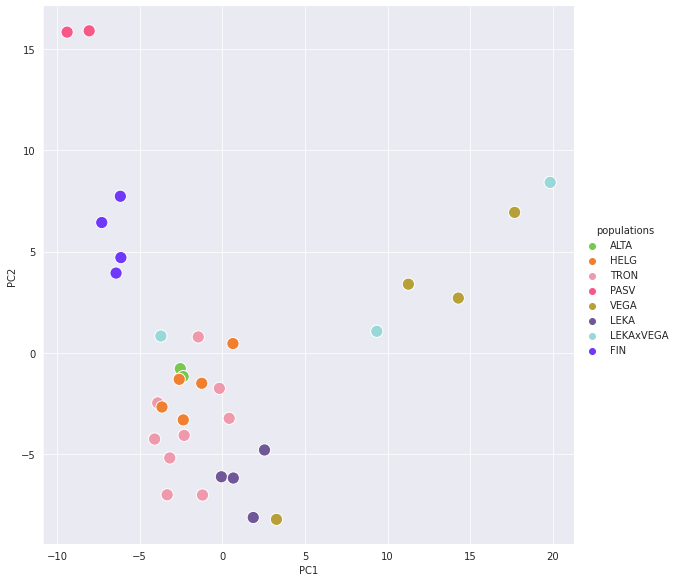

In [25]:
from matplotlib import pyplot
import seaborn


sns.relplot(x="PC1", y="PC2", data=merged2, hue="populations", palette=colours, s=(150),height=8, aspect=1)

***PART 2. PLOT ALL REJECTED DELETIONS (SCORED AS "NO" BY AT LEAST ONE CURATOR)***

In [71]:
%%bash

bedtools intersect -v -a SV_altgenos.bed -b yesmaybeallintersect.txt > rejected_all.bed

Extract only deletions from the resulting .bed file

In [72]:
%%bash
#Set the SV class

SV=DEL 
cat rejected_all.bed | grep "DEL" > rejected_all_${SV}.bed

***Change format of intersected bedfile, repeat this to join 3 first columns with tabs***

In [73]:
%%bash
#Set the SV class

SV=DEL 

cat rejected_all_${SV}.bed | sed 's/0\/0/0/g' | sed 's/0\/1/1/g' | sed 's/1\/1/2/g'| sed 's/.\/\./0/g' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' > rejected_all_${SV}_edit.txt 

***Convert to .csv for export to Python, to tranpose matrix***

In [74]:
%%bash
#Set the SV class

SV=DEL 

cat rejected_all_${SV}_edit.txt | sed 's/\t/,/'g > rejected_all_edit.csv

In [75]:
import numpy as np
import pandas as pd

df = pd.read_csv("rejected_all_edit.csv", header = None, index_col = None)

df_T = df.transpose()

df_T.to_csv("rejected_all_T.csv", index = False)

Remove first line

In [76]:
%%bash
sed -i -e 1,1d rejected_all_T.csv 

***Now plot in Python!***

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [78]:
df = pd.read_csv("rejected_all_T.csv")
hs = pd.read_csv("HS.sample.csv")
df

,CM004525.1_69685_70178_DEL,CM004525.1_83292_83620_DEL,CM004525.1_83758_84400_DEL,CM004525.1_84072_84367_DEL,CM004525.1_116388_118179_DEL,CM004525.1_142504_144352_DEL,CM004525.1_152957_153556_DEL,CM004525.1_192298_192672_DEL,CM004525.1_217652_217732_DEL,CM004525.1_234980_366718_DEL,...,CM004554.1_3266132_3266820_DEL,CM004554.1_3272734_3274222_DEL,CM004554.1_3272735_3274901_DEL,CM004554.1_3285689_3286800_DEL,CM004554.1_3293614_3294606_DEL,CM004554.1_3378163_3378562_DEL,CM004554.1_3458698_3461289_DEL,CM004554.1_3461380_3466508_DEL,CM004554.1_3479906_3486030_DEL,CM004554.1_3514583_3515112_DEL
0,0,1,1,2,0,0,2,0,2,0,...,0,1,1,0,0,0,1,0,2,2
1,0,1,1,2,2,0,2,0,0,1,...,2,2,0,0,0,2,2,0,2,2
2,0,1,1,1,2,1,2,0,2,1,...,2,1,0,1,0,2,2,0,2,2
3,1,1,0,1,0,0,2,0,2,1,...,2,1,0,1,0,2,1,2,2,2
4,0,1,0,1,2,0,2,0,0,1,...,0,2,2,0,0,0,0,0,2,2
5,0,2,1,1,2,0,2,0,0,1,...,2,1,0,0,0,0,1,2,2,2
6,0,1,0,2,1,0,2,0,0,1,...,2,0,1,0,0,0,1,0,2,2
7,0,2,1,2,0,0,2,1,0,1,...,2,2,0,0,0,0,1,0,2,2
8,0,1,1,1,0,0,2,0,0,1,...,2,2,1,0,0,2,1,1,2,2
9,1,2,1,1,2,0,2,2,2,1,...,2,1,0,0,1,0,1,1,2,2


In [79]:
import plotly.express as px
from sklearn.decomposition import PCA

X = df


In [80]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

components 

array([[ -3.13899025,  -0.2017459 ],
       [  7.78141299,   6.8168496 ],
       [ -8.64258777,  -4.04581025],
       [ -0.15366429,   8.10922485],
       [-13.86709631,  -4.00304542],
       [  2.46626477,  11.17644524],
       [-19.83103376, -24.93273786],
       [-17.04324103,   8.00000073],
       [ -5.02152701,  20.69428016],
       [ -1.55384517,   5.63362039],
       [-19.08000826, -21.83743492],
       [ 27.06736415,  -9.68605965],
       [ -7.43088315, -12.95087061],
       [  4.24516689,  -2.60400311],
       [ 23.37811314, -15.66616829],
       [ -8.29536589, -16.40300237],
       [ -1.61930467,   0.96455533],
       [ -9.78787957,   0.80246504],
       [ -9.0202393 ,  -1.87816907],
       [ -0.42250177,  -6.97628608],
       [ 23.2411294 ,  -0.73465652],
       [  4.14542779,   7.81416291],
       [ -7.30366907, -12.14771027],
       [  2.89530434,   2.73626871],
       [ -3.02610893,   2.83867079],
       [  1.55443227,   4.09898905],
       [ 31.92371709, -18.53943472],
 

In [81]:
pcomp = pd.DataFrame(components)

merged = pd.concat([pcomp, hs], axis=1)

merged['popinfo']
PC1 = merged.iloc[:, 0]
PC2 = merged.iloc[:, 1]

merged_n = merged.rename(columns={0: 'PC1'})
merged_new = merged_n.rename(columns={1: 'PC2'})

merged2 =  merged_new.rename(columns={'popinfo': 'populations'})

In [82]:
merged2

,PC1,PC2,populations
0,-3.138990,-0.201746,ALTA
1,7.781413,6.816850,ALTA
2,-8.642588,-4.045810,HELG
3,-0.153664,8.109225,TRON
4,-13.867096,-4.003045,TRON
5,2.466265,11.176445,TRON
6,-19.831034,-24.932738,HELG
7,-17.043241,8.000001,PASV
8,-5.021527,20.694280,PASV
9,-1.553845,5.633620,TRON


In [83]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

	
# Set theme
sns.set_style('darkgrid')

colours = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#EE99AC',  # Fairy
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
	

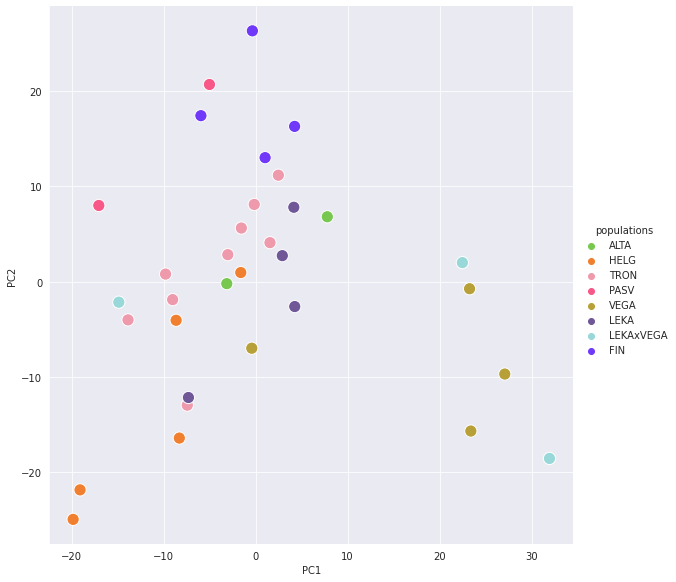

In [84]:
from matplotlib import pyplot
import seaborn


sns.relplot(x="PC1", y="PC2", data=merged2, hue="populations", palette=colours, s=(150),height=8, aspect=1)

***PART 3. PLOT ALL UNCURATED DELETIONS***

Extract uncurated SVs from the bcftools query .bed file

In [110]:
%%bash
#Set the SV class

SV=DEL 
cat SV_altgenos.bed | grep "DEL" > uncurated_all_${SV}.bed

In [111]:
%%bash
#Set the SV class

SV=DEL 

cat uncurated_all_${SV}.bed | sed 's/0\/0/0/g' | sed 's/0\/1/1/g' | sed 's/1\/1/2/g'| sed 's/.\/\./0/g' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' | sed -e 's/[\t ]\+/_/' > uncurated_all_${SV}_edit.txt 

***Convert to .csv for export to Python, to tranpose matrix***

In [112]:
%%bash
#Set the SV class

SV=DEL 

cat uncurated_all_${SV}_edit.txt | sed 's/\t/,/'g > uncurated_all_edit.csv

In [113]:
import numpy as np
import pandas as pd

df = pd.read_csv("uncurated_all_edit.csv", header = None, index_col = None)

df_T = df.transpose()

df_T.to_csv("uncurated_all_T.csv", index = False)

Remove first line

In [114]:
%%bash
sed -i -e 1,1d uncurated_all_T.csv 

***Now plot in Python!***

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [132]:
df = pd.read_csv("uncurated_all_T.csv")
hs = pd.read_csv("HS.sample.csv")
df

,CM004525.1_69685_70178_DEL,CM004525.1_70489_413631_DEL,CM004525.1_83292_83620_DEL,CM004525.1_83758_84400_DEL,CM004525.1_84072_84367_DEL,CM004525.1_110201_425053_DEL,CM004525.1_116388_118179_DEL,CM004525.1_142504_144352_DEL,CM004525.1_152957_153556_DEL,CM004525.1_192298_192672_DEL,...,CM004554.1_3266132_3266820_DEL,CM004554.1_3272734_3274222_DEL,CM004554.1_3272735_3274901_DEL,CM004554.1_3285689_3286800_DEL,CM004554.1_3293614_3294606_DEL,CM004554.1_3378163_3378562_DEL,CM004554.1_3458698_3461289_DEL,CM004554.1_3461380_3466508_DEL,CM004554.1_3479906_3486030_DEL,CM004554.1_3514583_3515112_DEL
0,0,0,1,1,2,0,0,0,2,0,...,0,1,1,0,0,0,1,0,2,2
1,0,1,1,1,2,1,2,0,2,0,...,2,2,0,0,0,2,2,0,2,2
2,0,1,1,1,1,1,2,1,2,0,...,2,1,0,1,0,2,2,0,2,2
3,1,0,1,0,1,1,0,0,2,0,...,2,1,0,1,0,2,1,2,2,2
4,0,2,1,0,1,1,2,0,2,0,...,0,2,2,0,0,0,0,0,2,2
5,0,1,2,1,1,0,2,0,2,0,...,2,1,0,0,0,0,1,2,2,2
6,0,1,1,0,2,1,1,0,2,0,...,2,0,1,0,0,0,1,0,2,2
7,0,1,2,1,2,1,0,0,2,1,...,2,2,0,0,0,0,1,0,2,2
8,0,1,1,1,1,1,0,0,2,0,...,2,2,1,0,0,2,1,1,2,2
9,1,1,2,1,1,1,2,0,2,2,...,2,1,0,0,1,0,1,1,2,2


In [133]:
import plotly.express as px
from sklearn.decomposition import PCA

X = df


In [134]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

components 

array([[ -6.01797222,   1.39380765],
       [  2.72677406,   7.31298676],
       [ -5.38699765,  -8.46369666],
       [ -1.18887439,   1.71687482],
       [ -8.89499556, -14.47327   ],
       [ -1.40699735,   7.21197873],
       [-14.33218983, -24.42996791],
       [-19.04808944,  15.62298826],
       [-13.16379616,  29.41085005],
       [ -2.88988826,   5.66105991],
       [-15.36904862, -23.79340411],
       [ 32.71379239,   2.58313503],
       [ -3.3223488 , -14.34075575],
       [  5.01261057,  -5.76880078],
       [ 31.77897024,  -5.79197242],
       [ -8.43806738, -15.79357817],
       [ -2.41196096,  -4.26678313],
       [ -9.67268342,  -2.57590286],
       [ -9.34501563,  -7.37717532],
       [  1.85778947, -11.40687153],
       [ 25.91832046,   6.02411397],
       [  2.48390494,   0.52374336],
       [ -2.79796639, -15.02607657],
       [  2.15436307,  -1.50453546],
       [ -2.90794973,  -3.91585057],
       [  0.94807191,  -1.83889946],
       [ 41.2047956 ,  -3.12175668],
 

In [135]:
pcomp = pd.DataFrame(components)

merged = pd.concat([pcomp, hs], axis=1)

merged['popinfo']
PC1 = merged.iloc[:, 0]
PC2 = merged.iloc[:, 1]

merged_n = merged.rename(columns={0: 'PC1'})
merged_new = merged_n.rename(columns={1: 'PC2'})

merged2 =  merged_new.rename(columns={'popinfo': 'populations'})

In [136]:
merged2

,PC1,PC2,populations
0,-6.017972,1.393808,ALTA
1,2.726774,7.312987,ALTA
2,-5.386998,-8.463697,HELG
3,-1.188874,1.716875,TRON
4,-8.894996,-14.473270,TRON
5,-1.406997,7.211979,TRON
6,-14.332190,-24.429968,HELG
7,-19.048089,15.622988,PASV
8,-13.163796,29.410850,PASV
9,-2.889888,5.661060,TRON


In [137]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

	
# Set theme
sns.set_style('darkgrid')

colours = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#EE99AC',  # Fairy
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
	

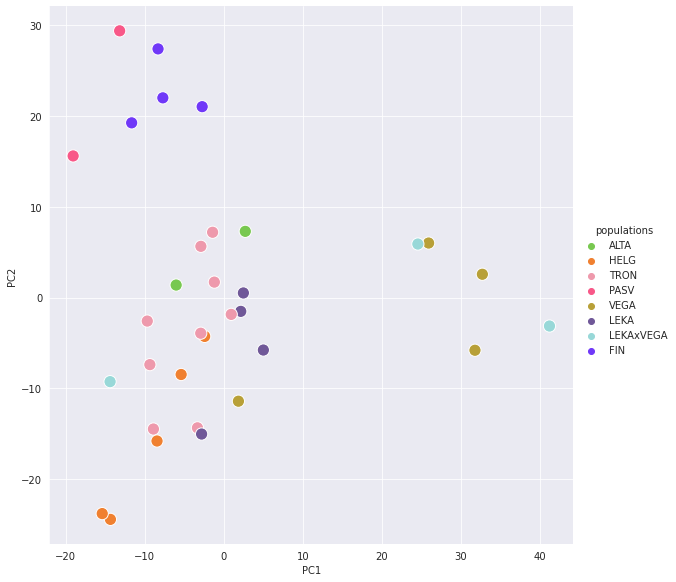

In [138]:
from matplotlib import pyplot
import seaborn


sns.relplot(x="PC1", y="PC2", data=merged2, hue="populations", palette=colours, s=(150),height=8, aspect=1)